## Initialisation du client ChromaDB persistant


In [2]:
import chromadb
import os


client = chromadb.PersistentClient(path="../data/chroma")

collections = client.list_collections()
print(f"Found {len(collections)} collections: {[c.name for c in collections]}")

train_collection = client.get_collection(name="train_collection")
test_collection  = client.get_collection(name="test_collection")


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given


Found 2 collections: ['test_collection', 'train_collection']


## Chargement des données et des embeddings depuis ChromaDB


In [ ]:
train_data = train_collection.get(include=["embeddings", "metadatas"])
test_data  = test_collection.get(include=["embeddings", "metadatas"])

X_train = train_data["embeddings"]
y_train = [m["label"] for m in train_data["metadatas"]]

X_test = test_data["embeddings"]
y_test = [m["label"] for m in test_data["metadatas"]]


Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event CollectionGetEvent: capture() takes 1 positional argument but 3 were given


## Model Training and Evaluation (Logistic Regression, SVM, Random Forest, Naive Bayes)


Model: LogReg
---- Training Metrics ----
Accuracy : 0.836
Precision: 0.785
Recall   : 0.833
F1-score : 0.805
---- Test Metrics ----
Accuracy : 0.816
Precision: 0.760
Recall   : 0.806
F1-score : 0.778
---- Performance Gap (Train - Test) ----
Accuracy Gap : 0.021
F1-score Gap : 0.026
Confusion Matrix:
 [[1509  225   84]
 [  78  474   61]
 [  21   64  375]]


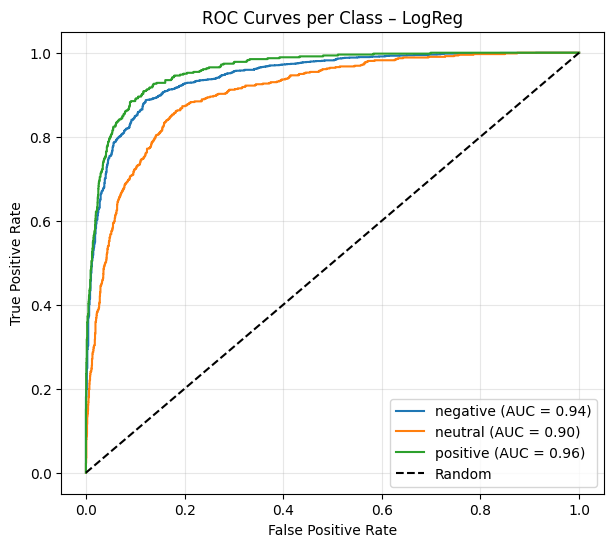

Model: SVM
---- Training Metrics ----
Accuracy : 0.842
Precision: 0.791
Recall   : 0.840
F1-score : 0.811
---- Test Metrics ----
Accuracy : 0.817
Precision: 0.760
Recall   : 0.809
F1-score : 0.779
---- Performance Gap (Train - Test) ----
Accuracy Gap : 0.025
F1-score Gap : 0.032
Confusion Matrix:
 [[1514  220   84]
 [  78  466   69]
 [  16   61  383]]


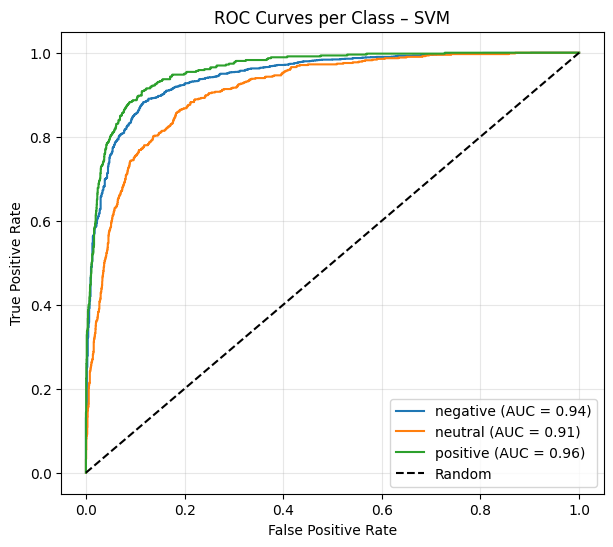

Model: RF
---- Training Metrics ----
Accuracy : 0.997
Precision: 0.994
Recall   : 0.995
F1-score : 0.994
---- Test Metrics ----
Accuracy : 0.797
Precision: 0.800
Recall   : 0.672
F1-score : 0.708
---- Performance Gap (Train - Test) ----
Accuracy Gap : 0.199
F1-score Gap : 0.286
Confusion Matrix:
 [[1764   28   26]
 [ 335  239   39]
 [ 120   38  302]]


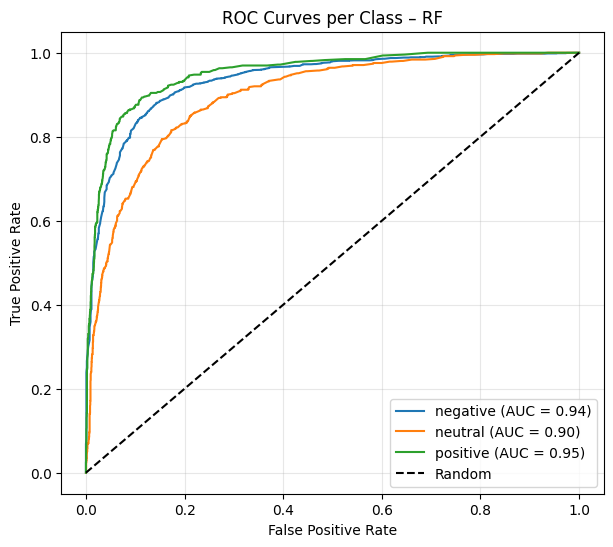

Model: NB
---- Training Metrics ----
Accuracy : 0.792
Precision: 0.741
Recall   : 0.778
F1-score : 0.755
---- Test Metrics ----
Accuracy : 0.784
Precision: 0.731
Recall   : 0.766
F1-score : 0.743
---- Performance Gap (Train - Test) ----
Accuracy Gap : 0.008
F1-score Gap : 0.011
Confusion Matrix:
 [[1470  277   71]
 [ 104  442   67]
 [  29   77  354]]


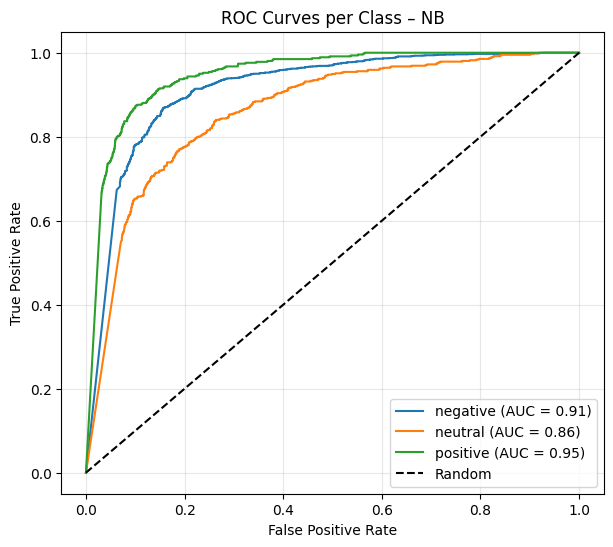

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

models = {
    "LogReg": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "SVM": SVC(kernel="linear", probability=True, class_weight="balanced"),
    "RF": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "NB": GaussianNB()
}

classes = ['negative', 'neutral', 'positive']
y_test_bin = label_binarize(y_test, classes=classes)

for name, model in models.items():

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    train_prec = precision_score(y_train, y_train_pred, average='macro')
    train_rec = recall_score(y_train, y_train_pred, average='macro')
    train_f1 = f1_score(y_train, y_train_pred, average='macro')

    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec = precision_score(y_test, y_test_pred, average='macro')
    test_rec = recall_score(y_test, y_test_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')

    print("=" * 60)
    print(f"Model: {name}")
    print("---- Training Metrics ----")
    print(f"Accuracy : {train_acc:.3f}")
    print(f"Precision: {train_prec:.3f}")
    print(f"Recall   : {train_rec:.3f}")
    print(f"F1-score : {train_f1:.3f}")

    print("---- Test Metrics ----")
    print(f"Accuracy : {test_acc:.3f}")
    print(f"Precision: {test_prec:.3f}")
    print(f"Recall   : {test_rec:.3f}")
    print(f"F1-score : {test_f1:.3f}")

    print("---- Performance Gap (Train - Test) ----")
    print(f"Accuracy Gap : {train_acc - test_acc:.3f}")
    print(f"F1-score Gap : {train_f1 - test_f1:.3f}")

    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

    plt.figure(figsize=(7, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves per Class – {name}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
